In [18]:
%matplotlib inline

import autograd.numpy as np
import matplotlib.pylab as plt
import seaborn as snb

from scipy.optimize import minimize
from autograd import value_and_grad

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


snb.set_style('darkgrid')
snb.set_theme(font_scale=1.25)


# plot six covariance functions

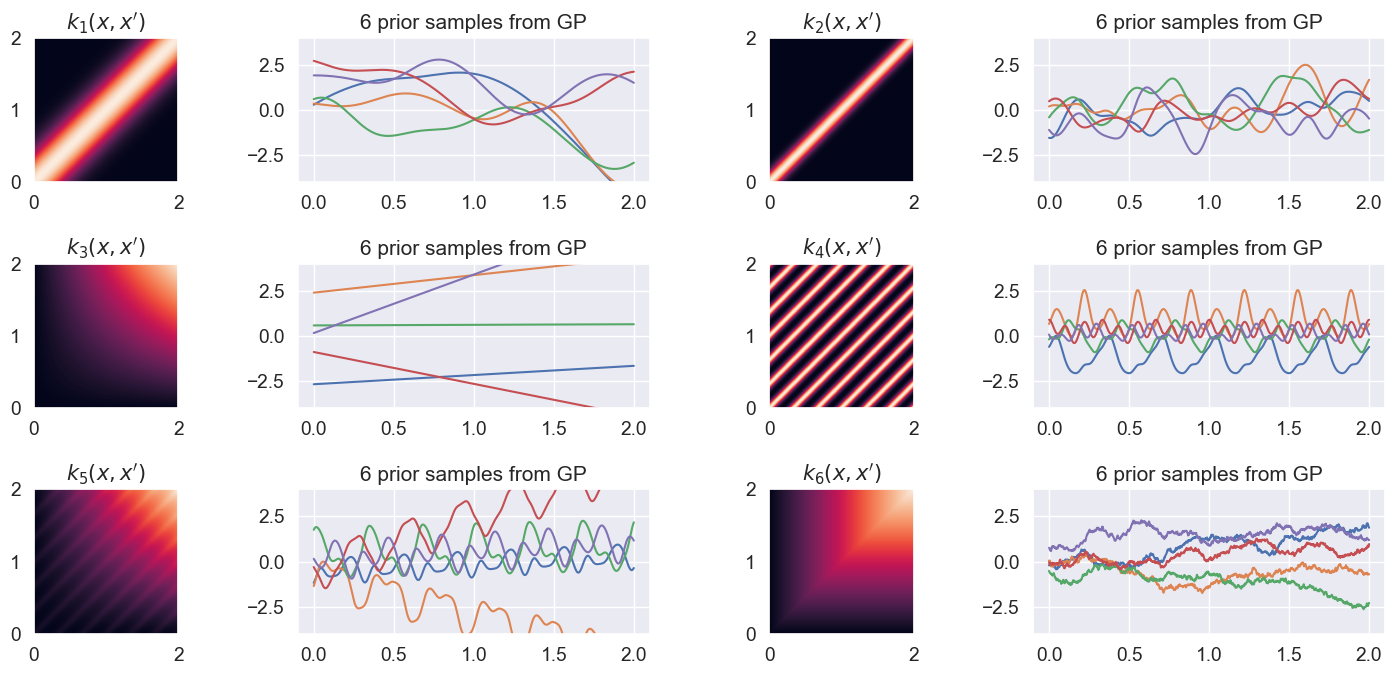

In [19]:
# Defining the different covariance functions
kernel_1 = lambda x,y: 2 * np.exp(- (x - y) ** 2 / (2 * 0.3 ** 2))
kernel_2 = lambda x,y: np.exp(- (x - y) ** 2 / (2 * 0.1 ** 2))
kernel_3 = lambda x,y: 4 + 2 * x * y
kernel_4 = lambda x,y: np.exp(-2 * np.sin(3 * np.pi * np.abs(x - y)) ** 2)
kernel_5 = lambda x,y: np.exp(-2 * np.sin(3 * np.pi * np.abs(x - y)) ** 2) + 4 * x * y
kernel_6 = lambda x,y: 0.2 + np.minimum(x,y)

# Generate samples from kernel
def generate_samples(K, jitter = 1e-8, num_samples = 20):
    L = np.linalg.cholesky(K + jitter * np.identity(K.shape[0]))
    f_samples_or = np.random.multivariate_normal(np.zeros(K.shape[0]), np.identity(K.shape[0]), num_samples)
    f_samples = L @ f_samples_or.T
    return f_samples
    
# Plot of the different kernels
X = np.linspace(0, 2, 1000)
xs, ys = np.meshgrid(X,X)
fig, ax = plt.subplots(3,4)
fig.set_figwidth(15)
fig.set_figheight(7)
kernels = [kernel_1, kernel_2, kernel_3, kernel_4, kernel_5, kernel_6]
for idx, ker in enumerate(kernels):
    row, col = idx // 2,    2 * (idx % 2)
    ax[row,col].grid(False)
    ax[row,col].pcolormesh(xs, ys, ker(xs, ys))
    ax[row,col].set_aspect('equal')
    ax[row,col].set_title(fr"$k_{idx+1}(x,x')$")
    ax[row,col+1].plot(X, generate_samples(ker(xs, ys), num_samples=5))
    ax[row,col+1].set_ylim(-4,4)
    ax[row,col+1].set_title("6 prior samples from GP")
plt.tight_layout()
plt.show()

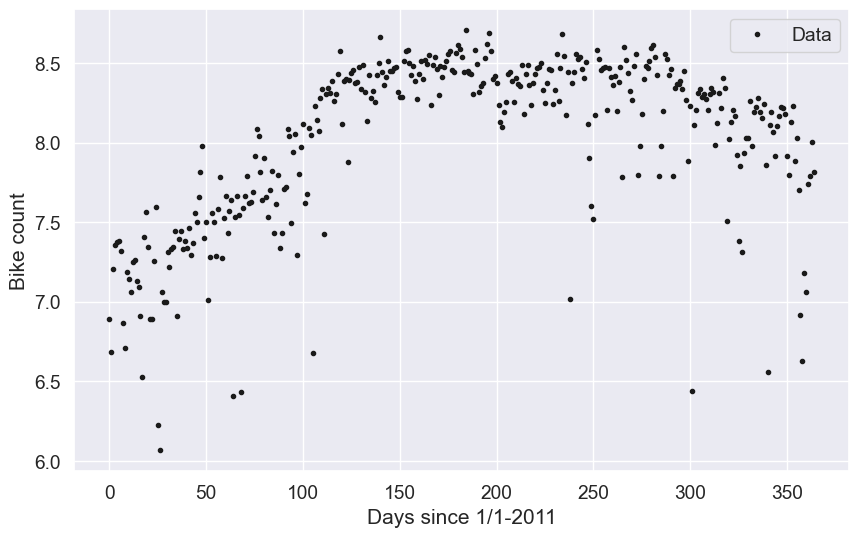

In [25]:
data = np.load('./data_exercise5b.npz')
day = data['day']
bike_count = data['bike_count']
# log-transform the data
bike_count= np.log(bike_count)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');
# for predictions
Xstar = np . arange (0 , 370) [: , None ]


In [26]:
def generate_samples(m, K, num_samples, jitter=0):
    """ returns M samples from an Gaussian process with mean m and kernel matrix K. The function generates num_samples of z ~ N(0, I) and transforms them into f  ~ N(m, K) via the Cholesky factorization.

    
    arguments:
        m                -- mean vector (shape (N,))
        K                -- kernel matrix (shape NxN)
        num_samples      -- number of samples to generate (positive integer)
        jitter           -- amount of jitter (non-negative scalar)
    
    returns 
        f_samples        -- a numpy matrix containing the samples of f (shape N x num_samples)
    """
    

    ##############################################
    # Your solution goes here
    ##############################################
    N = len(K)
    L = np.linalg.cholesky(K + jitter * np.identity(N)) # Cholesky factorization L.shape = (N, N)
    z_samples = np.random.normal(0,1,size=(N, num_samples)) # generate samples from N(0, I) z_samples.shape = (N, num_samples)
    f_samples = m[:, None] + L @ z_samples # transform z into f via the Cholesky factorization f_samples.shape = (N, num_samples)
    ##############################################
    # End of solution
    ##############################################

    # sanity check of dimensions
    assert f_samples.shape == (len(K), num_samples), f"The shape of f_samples appears wrong. Expected shape ({len(K)}, {num_samples}), but the actual shape was {f_samples.shape}. Please check your code. "
    return f_samples

        

In [27]:
class StationaryIsotropicKernel(object):

    def __init__(self, kernel_fun, kappa=1., lengthscale=1.0,tau=1.0):
        """
            the argument kernel_fun must be a function of three arguments kernel_fun(||tau||, kappa, lengthscale), e.g. 
            squared_exponential = lambda tau, kappa, lengthscale: kappa**2*np.exp(-0.5*tau**2/lengthscale**2)
        """
        self.kernel_fun = kernel_fun
        self.kappa = kappa
        self.lengthscale = lengthscale
        self.tau = tau # add tau there
    def contruct_kernel(self, X1, X2, kappa=None, lengthscale=None,tau=None, jitter=1e-8):
        """ compute and returns the NxM kernel matrix between the two sets of input X1 (shape NxD) and X2 (MxD) using the stationary and isotropic covariance function specified by self.kernel_fun
    
        arguments:
            X1              -- NxD matrix
            X2              -- MxD matrix
            kappa           -- magnitude (positive scalar)
            lengthscale     -- characteristic lengthscale (positive scalar)
            jitter          -- non-negative scalar
        
        returns
            K               -- NxM matrix    
        """

        # extract dimensions 
        N, M = X1.shape[0], X2.shape[0]

        # prep hyperparameters
        kappa = self.kappa if kappa is None else kappa
        lengthscale = self.lengthscale if lengthscale is None else lengthscale
        tau = self.tau if tau is None else tau
        ##############################################
        # Your solution goes here
        ##############################################
        # compute the pairwise distances
        #distance = np.linalg.norm(X1[:, None] - X2, axis=2) # distance.shape = (N, M)
        distance = np.sqrt(np.sum((np.expand_dims(X1, 1) - np.expand_dims(X2, 0))**2, axis=-1))
        K = self.kernel_fun(distance, kappa, lengthscale,tau)

        # add jitter to diagonal for numerical stability
        if len(X1) == len(X2) and np.allclose(X1, X2):
            K = K + jitter*np.identity(len(X1))
        ####
        ##############################################
        # End of solution
        ##############################################
        
        assert K.shape == (N, M), f"The shape of K appears wrong. Expected shape ({N}, {M}), but the actual shape was {K.shape}. Please check your code. "
        return K

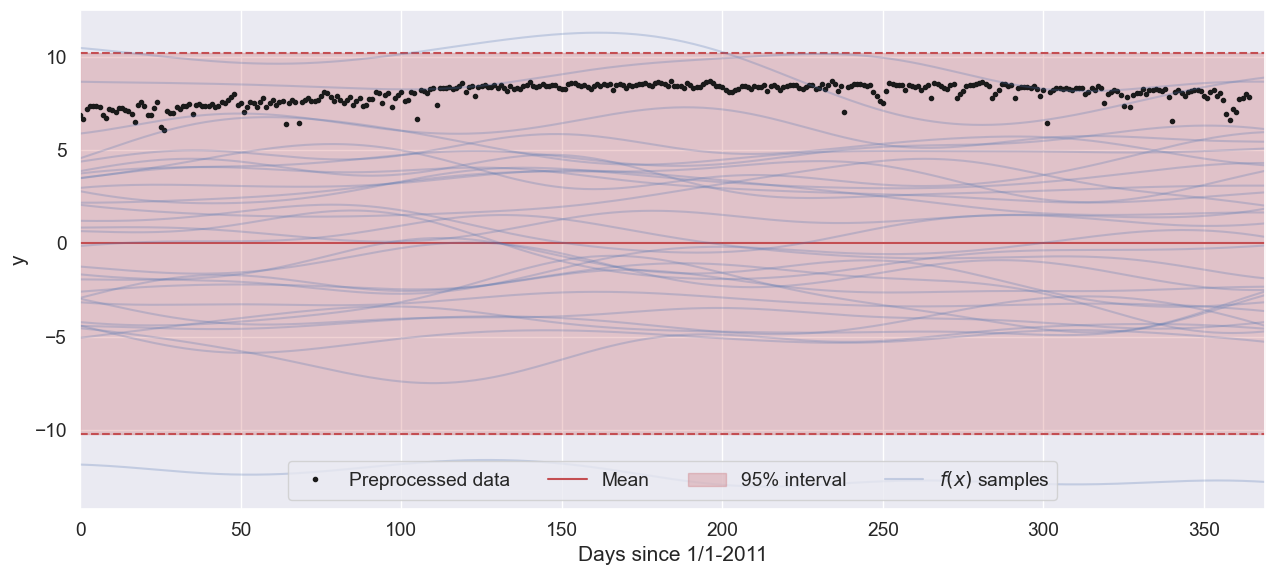

In [28]:
def kernel_f(dist,kappa,lengthscale,tau):
    return kappa**2*np.exp(-0.5*dist**2/lengthscale**2) + tau**2

def plot_with_uncertainty(ax, Xp, gp, color='r', color_samples='b', title="", num_samples=0):
    
    mu, Sigma = gp.predict_y(Xp)
    mean = mu.ravel()
    std = np.sqrt(np.diag(Sigma))

    # plot distribution
    ax.plot(Xp, mean, color=color, label='Mean')
    ax.plot(Xp, mean + 2*std, color=color, linestyle='--')
    ax.plot(Xp, mean - 2*std, color=color, linestyle='--')
    ax.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='95% interval')
    
    # generate samples
    if num_samples > 0:
        fs = gp.posterior_samples(Xstar, num_samples)
        ax.plot(Xp, fs[:,0], color=color_samples, alpha=.25, label="$f(x)$ samples")
        ax.plot(Xp, fs[:, 1:], color=color_samples, alpha=.25)
    
    ax.set_title(title)
    
# instantiate kernel
kernel = StationaryIsotropicKernel(kernel_fun=kernel_f)


class GaussianProcessRegression(object):

    def __init__(self, X, y, kernel, kappa=1, lengthscale=50,tau=5, sigma=0.1, jitter=1e-8):
        """  
        Arguments:
            X                -- NxD input points
            y                -- Nx1 observed values 
            kernel           -- must be instance of the StationaryIsotropicKernel class
            jitter           -- non-negative scaler
            kappa            -- magnitude (positive scalar)
            lengthscale      -- characteristic lengthscale (positive scalar)
            sigma            -- noise std. dev. (positive scalar)
        """
        self.X = X
        self.y = y
        self.N = len(X)
        self.kernel = kernel
        self.jitter = jitter
        self.set_hyperparameters(kappa, lengthscale, sigma,tau)

    def set_hyperparameters(self, kappa, lengthscale, sigma,tau):
        self.kappa = kappa
        self.lengthscale = lengthscale
        self.sigma = sigma
        self.tau = tau
    def posterior_samples(self, Xstar, num_samples):
        """
            generate samples from the posterior p(f^*|y, x^*) for each of the inputs in Xstar

            Arguments:
                Xstar            -- PxD prediction points
        
            returns:
                f_samples        -- numpy array of (P, num_samples) containing num_samples for each of the P inputs in Xstar
        """

        mu, Sigma = self.predict_f(Xstar)
        f_samples = generate_samples(mu.ravel(), Sigma, num_samples)
   
        assert (f_samples.shape == (len(Xstar), num_samples)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, {num_samples}), but actual shape was {f_samples.shape}. Please check implementation"
        return f_samples
        
    def predict_y(self, Xstar):
        """ returns the posterior distribution of y^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        mu               -- Px1 mean vector
        Sigma            -- PxP covariance matrix
        """
        mu,Sigma = self.predict_f(Xstar)
        Sigma = Sigma + self.sigma**2*np.identity(len(mu))
        return mu, Sigma

    def predict_f(self, Xstar):
        """ returns the posterior distribution of f^* evaluated at each of the points in x^* conditioned on (X, y)
        
        Arguments:
        Xstar            -- PxD prediction points
        
        returns:
        mu               -- Px1 mean vector
        Sigma            -- PxP covariance matrix
        """
        k = kernel.contruct_kernel(Xstar, self.X, self.kappa, self.lengthscale, self.tau,jitter=self.jitter) # k is the kernel matrix between the prediction points and the training data,k.shape = (P, N)
        K = kernel.contruct_kernel(self.X, self.X, self.kappa, self.lengthscale,self.tau, jitter=self.jitter) # K is the kernel matrix of the training data K.shape = (N, N)
        Kstar = kernel.contruct_kernel(Xstar, Xstar, self.kappa, self.lengthscale,self.tau, jitter=self.jitter) # Kstar is the kernel matrix of the prediction points Kstar.shape = (P, P)

        # compute the C matrix
        C = K + self.sigma**2*np.identity(len(self.X)) # C matrix is the covariance matrix of the training data with added noise C.shape = (N, N)

        # compute the mean and covariance of the posterior
        mu = k @ np.linalg.inv(C) @ self.y
        Sigma = Kstar - k @ np.linalg.inv(C) @ k.T
        #mu = np.dot(k, np.linalg.solve(C, self.y))
        #Sigma = Kstar - np.dot(k, np.linalg.solve(C, k.T))

        # sanity check for dimensions
        assert (mu.shape == (len(Xstar), 1)), f"The shape of the posterior mu seems wrong. Expected ({len(Xstar)}, 1), but actual shape was {mu.shape}. Please check implementation"
        assert (Sigma.shape == (len(Xstar), len(Xstar))), f"The shape of the posterior Sigma seems wrong. Expected ({len(Xstar)}, {len(Xstar)}), but actual shape was {Sigma.shape}. Please check implementation"

        return mu, Sigma
    
    def log_marginal_likelihood(self, kappa, lengthscale, sigma,tau):
        """ 
            evaluate the log marginal likelihood p(y) given the hyperparaemters 

            Arguments:
            kappa       -- positive scalar 
            lengthscale -- positive scalar
            sigma       -- positive scalar
            """
        K = self.kernel.contruct_kernel(self.X, self.X, kappa, lengthscale, tau) # K is the kernel matrix of the training data K.shape = (N, N)
        C = K + sigma**2*np.identity(self.N) # C matrix is the covariance matrix of the training data with added noise C.shape = (N, N)

        # compute the Cholesky factorization of C
        L = np.linalg.cholesky(C)
        v = np.linalg.solve(L, self.y)

        # compute the log marginal likelihood
        logdet_term = np.sum(np.log(np.diag(L)))
        quad_term = 0.5 * np.sum(v**2)
        const_term = -0.5 * N * np.log(2*np.pi)

        return const_term - logdet_term - quad_term
      
tau = 5.0
l = 50
sigma = 1.0
kappa = 1.0


gp_prior = GaussianProcessRegression(np.zeros((0, 1)), np.zeros((0, 1)), kernel)
Xstar = np.arange(0, 370)[:, None]
# visualize
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(day, bike_count, 'k.', label='Preprocessed data')
plot_with_uncertainty(ax, Xstar, gp_prior, num_samples=30)
ax.legend(loc='lower center', ncol=4)
ax.set(xlabel='Days since 1/1-2011', ylabel='y')
ax.set_xlim(Xstar.min(), Xstar.max())
plt.tight_layout()
plt.show()

In [29]:
def optimize_hyperparameters(gp, theta_init):

    # define optimization objective as the negative log marginal likelihood
    objective = lambda params: -gp.log_marginal_likelihood(np.exp(params[0]), np.exp(params[1]), np.exp(params[2]),np.exp(params[3]))

    # optimize using gradients
    res = minimize(value_and_grad(objective), np.log(theta_init), jac=True)

    # check for success
    if not res.success:
        print('Warning: optimization failed!')

    # return resultss
    theta = np.exp(res.x)
    return theta


Estimated hyperparameters
	sigma: 0.30
	kappa: 0.63
	scale: 82.67
	tau: 7.66


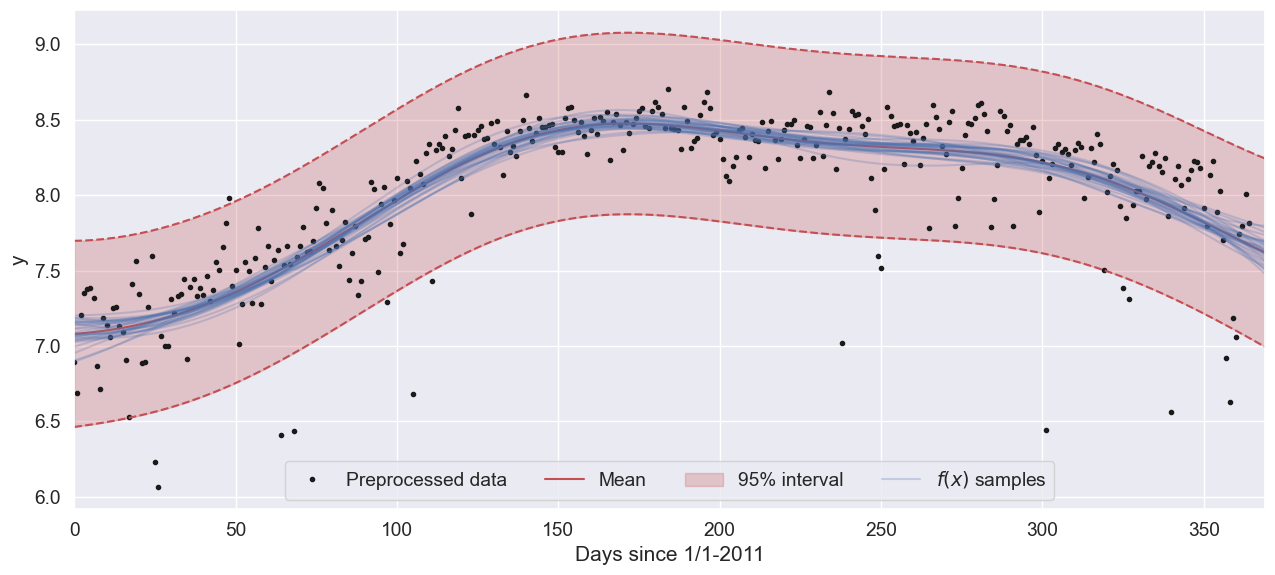

In [30]:
gp = GaussianProcessRegression(day, bike_count, kernel)

# optimize hyperparameters
kappa_hat,scla_hat,sigma_hat,tau_hat = optimize_hyperparameters(gp, np.array([1,1,1,1]))

gp.set_hyperparameters(kappa_hat, scla_hat, sigma_hat,tau_hat)

# print
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')
print(f'\tkappa: {kappa_hat:3.2f}')
print(f'\tscale: {scla_hat:3.2f}')
print(f'\ttau: {tau_hat:3.2f}')
# generate samples from the posterior
Xstar = np.arange(0, 370)[:, None]
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
ax.plot(day, bike_count, 'k.', label='Preprocessed data')
plot_with_uncertainty(ax, Xstar, gp, num_samples=30)
ax.legend(loc='lower center', ncol=4)
ax.set(xlabel='Days since 1/1-2011', ylabel='y')
ax.set_xlim(Xstar.min(), Xstar.max())
plt.tight_layout()
plt.show()